In [1]:
import csv

import pandas as pd

import numpy as np

import torch

from torch import nn, optim

from torch.autograd import Variable

from torch.utils.data import Dataset

from torch.utils.data import DataLoader

import time

import matplotlib.pyplot as plt

In [2]:
# 定义自己的类
class MyDataset(Dataset):
    
    # 初始化
    def __init__(self, file_name):
        # 读入数据
        self.data = pd.read_csv(file_name)
    
    # 返回df的长度
    def __len__(self):
        return len(self.data)
    
    # 获取第idx+1列的数据
    def __getitem__(self, idx):
        return self.data.values[idx,1:10]

# 通过实例化对象来访问该类
# 假设同目录下存在名为median_benchmark.csv的文件
ds = MyDataset('formatweather.csv')
ds=np.asarray(ds[:], dtype = np.float32)#####源文件float32 ,不知道为什么读取变为float64，这里再进行处理  最大最小化时变化
##dl = DataLoader(ds, batch_size=100, shuffle=False)

#####处理为torch，分为trainx，trainy
torchds=torch.from_numpy(ds[:])

In [3]:
train_dataset =torchds[:30700]  ##0.7*43823
test_dataset =torchds[30700:]
dl = DataLoader(train_dataset, batch_size=100, shuffle=True)

In [4]:
# 定义 Recurrent Network 模型

class Rnn(nn.Module):

    def __init__(self, in_dim, hidden_dim, n_layer, n_class):

        super(Rnn, self).__init__()

        self.n_layer = n_layer

        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(in_dim, hidden_dim, n_layer, batch_first=True)

        self.classifier = nn.Linear(hidden_dim, n_class)



    def forward(self, x):

        # h0 = Variable(torch.zeros(self.n_layer, x.size(1),

        #   self.hidden_dim)).cuda()

        # c0 = Variable(torch.zeros(self.n_layer, x.size(1),

        #   self.hidden_dim)).cuda()

        out, _ = self.lstm(x) #out 100 28 128 _ [0]2 100 128 [1]2 100 128

        out = out[:, -1, :]  #100,128

        out = self.classifier(out) #100,10

        return out


In [5]:
model = Rnn(8, 4, 2, 1)  
##model.load_state_dict(torch.load('./weathercnn.pth'))
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1) ####速度很快

In [6]:
#%%time 
losslist=[]
start = time.clock()
for epoch in range(200):
 
    print('epoch {}'.format(epoch + 1))

    print('*' * 10)

    running_loss = 0.0

    for i, data in enumerate(dl, 1):
        
            train_x=data[:,0:8]
            
            train_x=train_x.view(-1,1,8)
            
            train_y=data[:,8]
            
            train_y=train_y.view(-1,1)
            
            train_x=Variable(train_x)
            
            train_y=Variable(train_y)
        
            out = model(train_x)

            loss = criterion(out, train_y)
            
            running_loss += loss.item() * train_y.size(0)
            

            # 向后传播

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
            
    losslist.append(running_loss / (len(train_dataset)))   
           
                
    print('running_loss:-------')
    print(running_loss / (len(train_dataset)))     #0.0007139778983626053       
    #print(out,train_y)
print(time.clock()-start)  #119.2954125  2-321.5299771

I:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


epoch 1
**********
running_loss:-------
0.008769355925158005
epoch 2
**********
running_loss:-------
0.008248067989563176
epoch 3
**********
running_loss:-------
0.00823696456236783
epoch 4
**********
running_loss:-------
0.008221254357158021
epoch 5
**********
running_loss:-------
0.008206985704297448
epoch 6
**********
running_loss:-------
0.008194377990924914
epoch 7
**********
running_loss:-------
0.008181535256632183
epoch 8
**********
running_loss:-------
0.008168986502500912
epoch 9
**********
running_loss:-------
0.008152974488862853
epoch 10
**********
running_loss:-------
0.00813821575024957
epoch 11
**********
running_loss:-------
0.008120334628326302
epoch 12
**********
running_loss:-------
0.008106962342349151
epoch 13
**********
running_loss:-------
0.008088239712840862
epoch 14
**********
running_loss:-------
0.00806792831148479
epoch 15
**********
running_loss:-------
0.008048934410766059
epoch 16
**********
running_loss:-------
0.008027134557233378
epoch 17
**********


running_loss:-------
0.0007135916866456137
epoch 132
**********
running_loss:-------
0.0007132619817218674
epoch 133
**********
running_loss:-------
0.0007139979879688835
epoch 134
**********
running_loss:-------
0.0007135849206212374
epoch 135
**********
running_loss:-------
0.0007125839804043593
epoch 136
**********
running_loss:-------
0.0007134049247585522
epoch 137
**********
running_loss:-------
0.0007130753300880789
epoch 138
**********
running_loss:-------
0.0007127981517954611
epoch 139
**********
running_loss:-------
0.0007126007431678941
epoch 140
**********
running_loss:-------
0.0007120734969429302
epoch 141
**********
running_loss:-------
0.000711801434004018
epoch 142
**********
running_loss:-------
0.0007125032620207962
epoch 143
**********
running_loss:-------
0.0007115136452321819
epoch 144
**********
running_loss:-------
0.0007119438801425682
epoch 145
**********
running_loss:-------
0.0007118092502311102
epoch 146
**********
running_loss:-------
0.000711941301751751

I:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


308.92651889999996


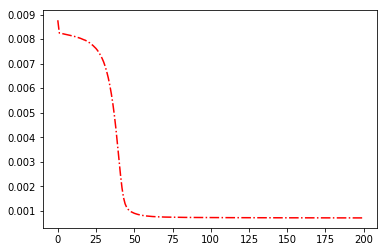

In [7]:
plt.plot(losslist,'r-.') 
plt.show()

In [8]:
out.detach().numpy().shape

(100, 1)

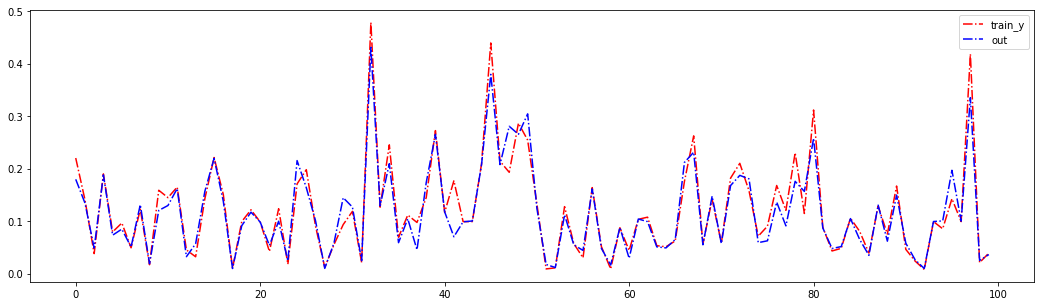

In [9]:
x=range(0,100)
plt.figure(num=1,figsize=(18,5))#定义编号为1 大小为(8,5)
plt.plot(x,train_y.numpy(),'r-.',label='train_y') 
plt.plot(x,out.detach().numpy(),'b-.',label='out') 
plt.legend(loc='best')#显示在最好的位置
plt.show()

In [10]:
model.eval()
    
test_x=test_dataset[:,0:8]

test_x=test_x.view(-1,1,8)

test_y=test_dataset[:,8]

test_y=test_y.view(-1,1)

test_x=Variable(test_x)

test_y=Variable(test_y)

out = model(test_x)


In [11]:
####计算准确率
acc=0
for i in range(13123):
    x=test_y.numpy()[i]-out.detach().numpy()[i]
    if abs(x)<=0.02:
        acc+=1
accuracy_rate=acc/13123
print(accuracy_rate)  ##0.7474662805760878  0.7697934923416901 0.8081231425741066 0.825040006096167

0.8280118875257182


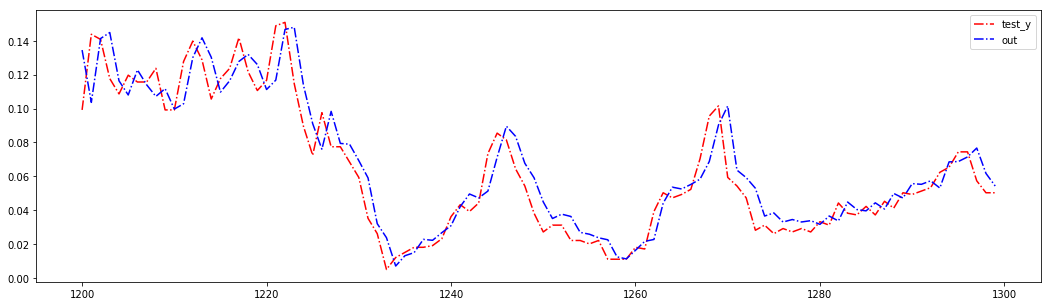

In [12]:
#x=range(0,13123)
x=range(1200,1300)
plt.figure(num=1,figsize=(18,5))#定义编号为1 大小为(8,5)
plt.plot(x,test_y.numpy()[1200:1300],'r-.',label='test_y') 
plt.plot(x,out.detach().numpy()[1200:1300],'b-.',label='out') 
plt.legend(loc='best')#显示在最好的位置
plt.show()

In [13]:
# 保存模型
torch.save(model.state_dict(), './weatherlstm-0.1-ture-7.17.pth')